# Importação de Bibliotecas

In [1]:
%pip install pyspark
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
#from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
#from pyspark.sql.functions import col, regexp_replace, expr
import matplotlib.ticker as ticker
#from pyspark.sql.functions import col, when
import pyspark.sql.functions as F
#from pyspark.sql.functions import regexp_extract
import pandas as pd
import seaborn as sns
#from pyspark.sql.functions import coalesce, lit
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
#from pyspark.sql.functions import col
#from pyspark.sql.functions import col, count
from pyspark.sql.functions import col, coalesce, lit, count, sum, when, regexp_replace, expr, regexp_extract

# Inicialização de sessão Spark

In [3]:
spark = SparkSession.builder \
    .appName("ExampleApp") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .master("local[7]") \
    .getOrCreate()

# Importação e Tratamento da base de dados

## Importação da Base

In [4]:
df = spark.read.csv(r"C:\Users\LuizFernandoDaCostaC\Box\pessoal\Pessoal\Pós\Job Review - Spark\all_reviews.csv", header=True, inferSchema=True)

In [5]:
df.show(10)

+-------------------+--------------------+--------------------+--------------------+--------------------+------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+--------------------+--------------------+--------------------+-----+
|             rating|               title|              status|                pros|                cons|advice|Recommend|CEO Approval|Business Outlook|Career Opportunities|Compensation and Benefits|Senior Management|Work/Life Balance|Culture & Values|Diversity & Inclusion|           firm_link|                date|                 job|index|
+-------------------+--------------------+--------------------+--------------------+--------------------+------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+--------------------+-----------------

dicionário da aprovação: v - Positive, r - Mild, x - Negative, o - No opinion

rating: número
data: data

In [6]:
df.columns
#coluna do dataframe

['rating',
 'title',
 'status',
 'pros',
 'cons',
 'advice',
 'Recommend',
 'CEO Approval',
 'Business Outlook',
 'Career Opportunities',
 'Compensation and Benefits',
 'Senior Management',
 'Work/Life Balance',
 'Culture & Values',
 'Diversity & Inclusion',
 'firm_link',
 'date',
 'job',
 'index']

In [7]:
df.printSchema()
#colunas do dataframe com o tipo de dado

root
 |-- rating: string (nullable = true)
 |-- title: string (nullable = true)
 |-- status: string (nullable = true)
 |-- pros: string (nullable = true)
 |-- cons: string (nullable = true)
 |-- advice: string (nullable = true)
 |-- Recommend: string (nullable = true)
 |-- CEO Approval: string (nullable = true)
 |-- Business Outlook: string (nullable = true)
 |-- Career Opportunities: string (nullable = true)
 |-- Compensation and Benefits: string (nullable = true)
 |-- Senior Management: string (nullable = true)
 |-- Work/Life Balance: string (nullable = true)
 |-- Culture & Values: string (nullable = true)
 |-- Diversity & Inclusion: string (nullable = true)
 |-- firm_link: string (nullable = true)
 |-- date: string (nullable = true)
 |-- job: string (nullable = true)
 |-- index: string (nullable = true)



In [8]:
df.select("rating").distinct().show()
#pegando apenas valores únicos da coluna de rating
#queria verificar se eram números classificados erroneamente como string ou se realmente era texto
#minha impressão é que os ratings seriam notas, mas também pode ter sido informação preenchida errada pelos usuários

depois de olhar a base original, não faz sentido a informação acima, pois rating deveria ser número, então houve algum erro na importação da base

In [ ]:
df = spark.read.csv(r"C:\Users\LuizFernandoDaCostaC\Box\pessoal\Pessoal\Pós\Job Review - Spark\all_reviews.csv", multiLine=True, header=True, inferSchema=True)
#precisei reimportar a base de dados, pois da forma anterior estava puxando colunas em campos indevidos
#dessa forma o df fica formatado da forma correta

In [ ]:
df.show(10)
#a base parece ter sido importada de forma correta agora

+------+--------------------+--------------------+--------------------+--------------------+------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+--------------------+-------------+--------------------+-----+
|rating|               title|              status|                pros|                cons|advice|Recommend|CEO Approval|Business Outlook|Career Opportunities|Compensation and Benefits|Senior Management|Work/Life Balance|Culture & Values|Diversity & Inclusion|           firm_link|         date|                 job|index|
+------+--------------------+--------------------+--------------------+--------------------+------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+--------------------+-------------+--------------------+-----+
|   5.0|                Good

In [ ]:
df.printSchema()
#tem algumas coisas de data e número que permanecem sendo importados como string

root
 |-- rating: string (nullable = true)
 |-- title: string (nullable = true)
 |-- status: string (nullable = true)
 |-- pros: string (nullable = true)
 |-- cons: string (nullable = true)
 |-- advice: string (nullable = true)
 |-- Recommend: string (nullable = true)
 |-- CEO Approval: string (nullable = true)
 |-- Business Outlook: string (nullable = true)
 |-- Career Opportunities: string (nullable = true)
 |-- Compensation and Benefits: string (nullable = true)
 |-- Senior Management: string (nullable = true)
 |-- Work/Life Balance: string (nullable = true)
 |-- Culture & Values: string (nullable = true)
 |-- Diversity & Inclusion: string (nullable = true)
 |-- firm_link: string (nullable = true)
 |-- date: string (nullable = true)
 |-- job: string (nullable = true)
 |-- index: string (nullable = true)



In [ ]:
df = df.repartition(7, 'rating')
#partindo a base em 7 para tornar mais rápido o processo de groupby

In [ ]:
df.groupBy('rating').count().limit(10).sort('count', ascending=False).show()

+--------------------+-------+
|              rating|  count|
+--------------------+-------+
|                 2.0|1020365|
|1) Email is the p...|      1|
|Outdated systems ...|      1|
|- Obvious conflic...|      1|
|Colleagues are pl...|      1|
|The company takes...|      1|
|-This company is ...|      1|
|-No coffee service\r|      1|
|-This company doe...|      1|
|- THIS COMPANY PA...|      1|
+--------------------+-------+



de acordo com as formas acima, ainda parece ter textos no lugar dos ratings, que deveriam ser apenas números

In [ ]:
df = df.coalesce(1)
#voltando a apenas uma partição

## Tratamento de Duplicidades

In [ ]:
df.count()

In [ ]:
df = df.dropDuplicates()

In [ ]:
df = df.drop('title', 'pros', 'cons')
#Demos drop nas colunas de pros, cons e title, pois são colunas sem padronização
#o empregado pode escrever oq quiser e pela falta de padronização não há como fazer uma análise mais aprofundada
#a menos que o objetivo fosse analisar as palavras em si e o que elas representam
#só deixamos elas até aqui para identificar as linhas duplicadas com mais eficiência

In [ ]:
df.count()

## Tratamento da coluna de rating

In [ ]:
problematic_entries = df.filter(col("rating").isin(["\r", "Also", "Overall", "Finally", "Lastly", "Oh", "NULL", "Additionally", "All in all", "So", "However", "In short", "-\"", "In addition"]))
problematic_entries.show(truncate=False)
#verificando todas as entradas em rating que não são números

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
misaligned_rows = df.filter(~col("rating").cast("float").isNotNull())
misaligned_rows.show(truncate=False)
#tentei analisar manualmente para verificar se algo poderia ser feito, mas sinceramente são muitos erros
#e distintos. Eu tentei procurar formas automáticas de resolver o problema mas nenhuma resolveu

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+-------------------------------------+-----------------------------------------------------------------------+------+---------+------------+----------------+--------------------+-------------------------+---------------------------------------+----------------------------------------------------------------+-------------------------------------------------------+----------------------------+---------------------------------+----+----+-----+
|rating                    

por não saber se o erro foi no preenchimento do site e vem desde o CSV ou se é um erro de importação, achei melhor realizar a retirada dos campos que claramente estão com problemas

In [ ]:
df = df.repartition(7, 'rating')

In [ ]:
cleaned_df = df.withColumn(
    "rating_cleaned", 
    regexp_replace(col("rating"), "[^0-9.]", "") 
)
#cria a coluna de rating_cleaned, removendo tudo da coluna de rating com exceção dos dígitos e dos decimais

valid_ratings_df = cleaned_df.filter(
    (col("rating_cleaned") != "") &
    (col("rating_cleaned").cast("float").isNotNull()) &
    (col("rating_cleaned").cast("float") >= 0) &
    (col("rating_cleaned").cast("float") <= 10)
)
#filtra os valores da coluna de rating, mantendo os valores entre 0 e 10

filtered_df = valid_ratings_df.filter(
    col("rating_cleaned").rlike(r"^\d+(\.\d{1,2})?$")  
)
#mesmo com a filtragem acima, ainda temos alguns valors com problema ligados a string
#pra isso, retiramos todos os valores que contém valores não numéricos

# Show the cleaned DataFrame to verify
filtered_df.select("rating_cleaned").distinct().show(truncate=False)
#mostra os valores distintos do data frame para checar se deu certo

+--------------+
|rating_cleaned|
+--------------+
|6.40          |
|7             |
|1.19          |
|5.00          |
|4.30          |
|9.2           |
|7.15          |
|3             |
|4.18          |
|8             |
|8.30          |
|0.25          |
|3.24          |
|4.5           |
|0.7           |
|0             |
|0.2           |
|2.12          |
|5.95          |
|7.25          |
+--------------+
only showing top 20 rows



In [ ]:
df = filtered_df

In [ ]:
df = df.coalesce(1)

In [ ]:
new_column_order = ["rating_cleaned"] + [col for col in filtered_df.columns if col != "rating_cleaned"]
reordered_df = filtered_df.select(*new_column_order)
reordered_df = reordered_df.drop("rating", "index")
df = reordered_df
#reordenando para que rating apareça na frente depois de criar a nova coluna apenas com valores de rating em número

In [ ]:
df = df.withColumnRenamed("rating_cleaned", "rating")

## Tratamento de valores do restante da base

In [ ]:
#v - Positive, r - Mild, x - Negative, o - No opinion
value_mapping = {
    'v': 'Positive',
    'r': 'Mild',
    'x': 'Negative',
    'o': 'No opinion'
}

df = df.replace(value_mapping, subset=['Recommend', 'CEO Approval', 'Business Outlook',])
#substituímos os valores acima, retirando do índice da base de dados, pelas palavras que eles correspondem

## Tratamento de Hyperlinks

In [ ]:
url_pattern = r'https?://\S+|www\.\S+'
df_cleaned = df.withColumn("firm_link", regexp_replace(col("firm_link"), url_pattern, "")) \
                .withColumn("date", regexp_replace(col("date"), url_pattern, ""))
#há alguns hyperlinks no texto, portanto foi necessário realizar a retirada desses formatos

In [ ]:
df = df_cleaned.drop("firm_link")
#por último retirei a coluna que tinham todos os links
#não foi possível realizar apenas essa etapa, pois devido a problemas na importação
# parte do hyperlink vazou para outras colunas da base, 
# por isso foi necessário fazer primeiro o tratamento e depois a retirada dessa coluna

## Tratamento das colunas de avaliação com string

In [ ]:
df = df.repartition(14, 'recommend')
#como recommend tem muitos valores distintos, devido a "vazão" de dados para outras colunas, dividi a coluna em 14 repartições ao invés de 7

In [ ]:
df.groupBy('recommend').count().limit(10).show()
#todas as colunas de avaliação apresentam o caso abaixo de texto no meio, sendo que deveriam ser apenas
#positive, negative, mild e no opinion

+--------------------+-----+
|           recommend|count|
+--------------------+-----+
|          favoritism|    5|
| and every move h...|    1|
| but they do have...|    1|
| but they will li...|    1|
| I'm ""underperfo...|    2|
| $11.25 per hour ...|    1|
| giving away Doll...|    1|
| turns department...|    1|
|   more from you""."|    1|
| or it is reflect...|    1|
+--------------------+-----+



In [ ]:
df.columns

['rating',
 'title',
 'status',
 'pros',
 'cons',
 'advice',
 'Recommend',
 'CEO Approval',
 'Business Outlook',
 'Career Opportunities',
 'Compensation and Benefits',
 'Senior Management',
 'Work/Life Balance',
 'Culture & Values',
 'Diversity & Inclusion',
 'date',
 'job']

In [ ]:
valid_values = ['Positive', 'Mild', 'Negative', 'No opinion']

df = df.withColumn("Recommend", when(col("Recommend").isin(valid_values), col("Recommend")).otherwise(None)) \
       .withColumn("CEO Approval", when(col("CEO Approval").isin(valid_values), col("CEO Approval")).otherwise(None)) \
       .withColumn("Business Outlook", when(col("Business Outlook").isin(valid_values), col("Business Outlook")).otherwise(None)) \
       .withColumn("Career Opportunities", when(col("Career Opportunities").isin(valid_values), col("Career Opportunities")).otherwise(None)) \
       .withColumn("Compensation and Benefits", when(col("Compensation and Benefits").isin(valid_values), col("Compensation and Benefits")).otherwise(None))

#substituição dos valores que não estão entre a legenda prevista para essas colunas por Null

## Tratamento da coluna de date

In [ ]:
df = df.repartition(14, 'date')

In [ ]:
df.select("date").distinct().show(truncate=False, n=20)

+---------------------------------------------------+
|date                                               |
+---------------------------------------------------+
|                                                   |
|x                                                  |
|Reviews/DXL-Big-&-Tall-Reviews-E1330.htm           |
|2                                                  |
|Reviews/Summa-Health-System-Reviews-E936195.htm    |
|Reviews/Alliance-Sports-Group-Reviews-E2482.htm    |
|Reviews/CA-Technologies-Reviews-E167.htm           |
|Reviews/Ansen-Corporation-Reviews-E196819.htm      |
|Reviews/Keithley-Instruments-Reviews-E916.htm      |
|Reviews/The-UPS-Store-Reviews-E646963.htm          |
|3.0                                                |
|5.0                                                |
|1.0                                                |
|3                                                  |
|Reviews/Agilant-Solutions,-Inc.-Reviews-E935654.htm|
|Reviews/Texas-A&M-Universit

In [ ]:
date_pattern = r'^\s*[A-Za-z]{3}\s+\d{1,2},\s+\d{4}\s*$'
#regex pra conseguirmos formatar a data

In [ ]:
df.select(F.trim(F.col("date")).alias("date_trimmed")).distinct().show(truncate=False, n=5)
#verificando o formato das datas

+-----------------------------------------------+
|date_trimmed                                   |
+-----------------------------------------------+
|                                               |
|x                                              |
|Reviews/DXL-Big-&-Tall-Reviews-E1330.htm       |
|2                                              |
|Reviews/Summa-Health-System-Reviews-E936195.htm|
+-----------------------------------------------+
only showing top 5 rows



In [ ]:
df_sample = df.select("date").distinct().limit(5)
df_sample = df_sample.withColumn("is_valid_date", F.trim(F.col("date")).rlike(date_pattern))
df_sample.show(truncate=False)
#verificando se o formato das datas é igual ao formato colocado acima

+-----------------------------------------------+-------------+
|date                                           |is_valid_date|
+-----------------------------------------------+-------------+
|                                               |false        |
|x                                              |false        |
|Reviews/DXL-Big-&-Tall-Reviews-E1330.htm       |false        |
|2                                              |false        |
|Reviews/Summa-Health-System-Reviews-E936195.htm|false        |
+-----------------------------------------------+-------------+



In [ ]:
df = df.withColumn("date", when(F.trim(F.col("date")).rlike(date_pattern), col("date")).otherwise(None))
df.show(10)
#vendo se deu certo e as datas não viraram todas null (esse foi um problema recorrente nas outras tentativas)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+----+-------------+
|rating|               title|              status|                pros|                cons|              advice|Recommend|CEO Approval|Business Outlook|Career Opportunities|Compensation and Benefits|Senior Management|Work/Life Balance|Culture & Values|Diversity & Inclusion|date|          job|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+----+-------------+
|   2.0|High expectations...|Former Employee, ...|Brilliant, hard-w...|"Oh man, I'm so s...|                NULL|  

In [ ]:
df.groupBy("date").count().orderBy(col("count").desc()).show(truncate=False)

+-------------+------+
|date         |count |
+-------------+------+
|NULL         |184206|
|Jan 11, 2021 |11078 |
|Jan 12, 2021 |10907 |
|Jan 13, 2021 |10608 |
|Jan 19, 2021 |10217 |
|Jan 14, 2021 |9809  |
|Sep 14, 2020 |9746  |
|Jan 20, 2021 |9613  |
|Jun 25, 2021 |9278  |
|Jan 21, 2021 |9261  |
|Jun 8, 2022  |9008  |
|Jan 18, 2021 |8839  |
|Feb 10, 2021 |8836  |
|Feb 2, 2021  |8744  |
|Feb 9, 2021  |8727  |
|Feb 23, 2021 |8631  |
|Jun 24, 2021 |8528  |
|Feb 3, 2021  |8526  |
|Feb 24, 2021 |8441  |
|Feb 17, 2021 |8366  |
+-------------+------+
only showing top 20 rows



In [ ]:
df = df.coalesce(1)

## Tratamento de Nulls

vamos verificar quais colunas possuem muitos resultados null para decidir se devem ser retiradas de futuras análises por terem muita informação faltante

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

In [ ]:
null_counts.show()

+------+-----+------+----+-----+-------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+------+-----+
|rating|title|status|pros| cons| advice|Recommend|CEO Approval|Business Outlook|Career Opportunities|Compensation and Benefits|Senior Management|Work/Life Balance|Culture & Values|Diversity & Inclusion|  date|  job|
+------+-----+------+----+-----+-------+---------+------------+----------------+--------------------+-------------------------+-----------------+-----------------+----------------+---------------------+------+-----+
|     0|41065|  3090|3578|12651|9777709|   183802|      143221|          122502|             9907317|                  9907317|          2059236|          1979501|         2310014|              6492463|184206|99885|
+------+-----+------+----+-----+-------+---------+------------+----------------+--------------------+-------------------------+---------

In [ ]:
df_null_pandas = null_counts.toPandas()

In [ ]:
df_null_pandas.head()

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job
0,0,41065,3090,3578,12651,9777709,183802,143221,122502,9907317,9907317,2059236,1979501,2310014,6492463,184206,99885


In [ ]:
df_null_pandas.index = ['null_count']
df_null_pandas

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,date,job
null_count,0,41065,3090,3578,12651,9777709,183802,143221,122502,9907317,9907317,2059236,1979501,2310014,6492463,184206,99885


In [ ]:
df_null_pandas.dtypes

rating                       int64
title                        int64
status                       int64
pros                         int64
cons                         int64
advice                       int64
Recommend                    int64
CEO Approval                 int64
Business Outlook             int64
Career Opportunities         int64
Compensation and Benefits    int64
Senior Management            int64
Work/Life Balance            int64
Culture & Values             int64
Diversity & Inclusion        int64
date                         int64
job                          int64
dtype: object

In [ ]:
df_transposed = df_null_pandas.transpose()

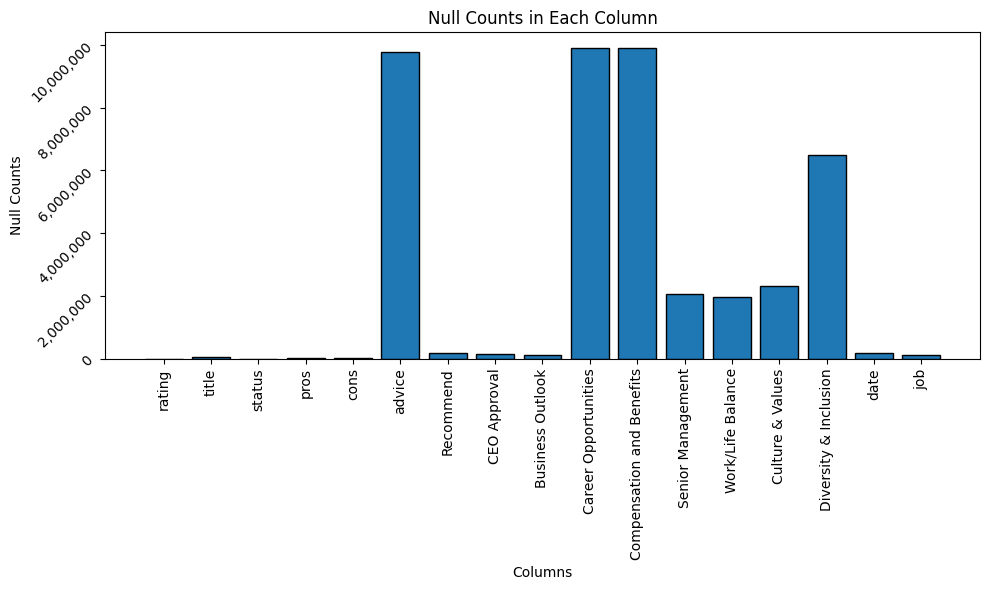

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_transposed.index, df_transposed['null_count'], edgecolor='black')
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.title('Null Counts in Each Column')
plt.xlabel('Columns')
plt.ylabel('Null Counts')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}')) #para mostrar os valores corretos em y, caso contrário fica aparecendo notação científica
plt.tight_layout()
plt.show()

pelo gráfico acima, vemos quatro colunas com número extremo de informações em branco: advice, career opportunities, compensation and benefits e Diversity & Inclusion
além disso, há outras colunas bem defasadas entre senior management e culture, que apesar de não serem tão gritantes quanto as quatro anteriores, ainda estão bem acima no valor de nulls

In [ ]:
df.columns

['rating',
 'title',
 'status',
 'pros',
 'cons',
 'advice',
 'Recommend',
 'CEO Approval',
 'Business Outlook',
 'Career Opportunities',
 'Compensation and Benefits',
 'Senior Management',
 'Work/Life Balance',
 'Culture & Values',
 'Diversity & Inclusion',
 'date',
 'job']

In [ ]:
df = df.drop('advice', 'Career Opportunities', 'Compensation and Benefits', 'Senior Management', 'Work/Life Balance', 'Culture & Values','Diversity & Inclusion',)

## Tratamento de Job

a coluna de job está com alguns valores remanescentes das frases que vazaram e não foram formatadas corretamente no início. Como não conseguimos criar esse limitador inicial, a abordagem será manter apenas os valores da coluna job que aparecerem mais de 1 vez, pois é bem difícil que alguma avaliação que tenha vazado para outras colunas da empresa tenha acabado da mesma forma e, se acabou, que tenha acabado da mesma forma e não tenha sido formatado corretamente

In [ ]:
df = df.repartition(14, 'job')

In [ ]:
job_counts = df.groupBy('job').agg(count('job').alias('count'))

jobs_to_keep = job_counts.filter(col('count') > 1).select('job')

df = df.join(jobs_to_keep, on='job', how='inner')
#filtragem apenas de Job que aparecem mais de 1 vez

In [ ]:
df.show(5)

+-----------------+------+--------------------+----------------+--------------------+--------------------+---------+------------+----------------+-------------+
|              job|rating|               title|          status|                pros|                cons|Recommend|CEO Approval|Business Outlook|         date|
+-----------------+------+--------------------+----------------+--------------------+--------------------+---------+------------+----------------+-------------+
|  Administrative |   2.0|better be a 'rock...| Former Employee|They don't hesita...|They work you lik...| Negative|        Mild|      No opinion| Sep 9, 2008 |
|  Administrative |   2.0|It may be a bumpy...| Former Employee|Flight benefits a...|Inconsistency on ...| Negative|        Mild|      No opinion| Jul 4, 2008 |
|  Administrative |   2.0|Fair Benefits - n...| Former Employee|The benefits are ...|Extreme Micro man...| Negative|    Positive|      No opinion|Jul 14, 2008 |
|  Administrative |   1.0|The Regi

## Tratamento de Status

In [ ]:
pattern = r'(Current Employee|Former Employee)'
#criando um padrão para current employee e former employee, porque a coluna de status tem muitos valores diferentes
#e não importa tanto para nós o tempo de cada um, mas o status do vínculo empregatício

df = df.withColumn('employee_status', regexp_extract('status', pattern, 0))
#criando nova coluna com o status resumido pra verificar se foi certo

df.show(10)

+-----------------+------+----------------+----------+------------+----------------+-------------+----------------+
|              job|rating|          status| Recommend|CEO Approval|Business Outlook|         date| employee_status|
+-----------------+------+----------------+----------+------------+----------------+-------------+----------------+
|  Administrative |   2.0| Former Employee|  Negative|        Mild|      No opinion| Sep 9, 2008 | Former Employee|
|  Administrative |   2.0| Former Employee|  Negative|        Mild|      No opinion| Jul 4, 2008 | Former Employee|
|  Administrative |   2.0| Former Employee|  Negative|    Positive|      No opinion|Jul 14, 2008 | Former Employee|
|  Administrative |   1.0| Former Employee|  Negative|        Mild|      No opinion|Aug 17, 2008 | Former Employee|
|  Administrative |   1.0|Current Employee|  Negative|    Negative|      No opinion| Jul 8, 2009 |Current Employee|
|  Administrative |   1.0| Former Employee|  Negative|        Mild|     

In [ ]:
#ajeitando a base
df = df.drop('status')
cols = ['rating', 'employee_status', 'Recommend', 'CEO Approval', 'Business Outlook', 'date', 'job']
df = df.select(cols)
df.show(10, truncate=False)

+------+----------------+----------+------------+----------------+-------------+-----------------+
|rating| employee_status| Recommend|CEO Approval|Business Outlook|         date|              job|
+------+----------------+----------+------------+----------------+-------------+-----------------+
|   2.0| Former Employee|  Negative|        Mild|      No opinion| Sep 9, 2008 |  Administrative |
|   2.0| Former Employee|  Negative|        Mild|      No opinion| Jul 4, 2008 |  Administrative |
|   2.0| Former Employee|  Negative|    Positive|      No opinion|Jul 14, 2008 |  Administrative |
|   1.0| Former Employee|  Negative|        Mild|      No opinion|Aug 17, 2008 |  Administrative |
|   1.0|Current Employee|  Negative|    Negative|      No opinion| Jul 8, 2009 |  Administrative |
|   1.0| Former Employee|  Negative|        Mild|      No opinion|Apr 25, 2009 |  Administrative |
|   3.0|Current Employee|No opinion|        Mild|      No opinion| Aug 5, 2009 |  Administrative |
|   5.0|Cu

# Análises

## Gráficos

In [ ]:
df = df.repartition(7, 'rating')

In [ ]:
current_df = df.filter(col('employee_status') == 'Current Employee')
rating_counts = current_df.groupBy('rating').count().collect()
rating_counts_df = pd.DataFrame(rating_counts, columns=['rating', 'count'])


In [ ]:
former_df = df.filter(col('employee_status') == 'Former Employee')
rating_counts_former = former_df.groupBy('rating').count().collect()
rating_counts_df_former = pd.DataFrame(rating_counts_former, columns=['rating', 'count'])

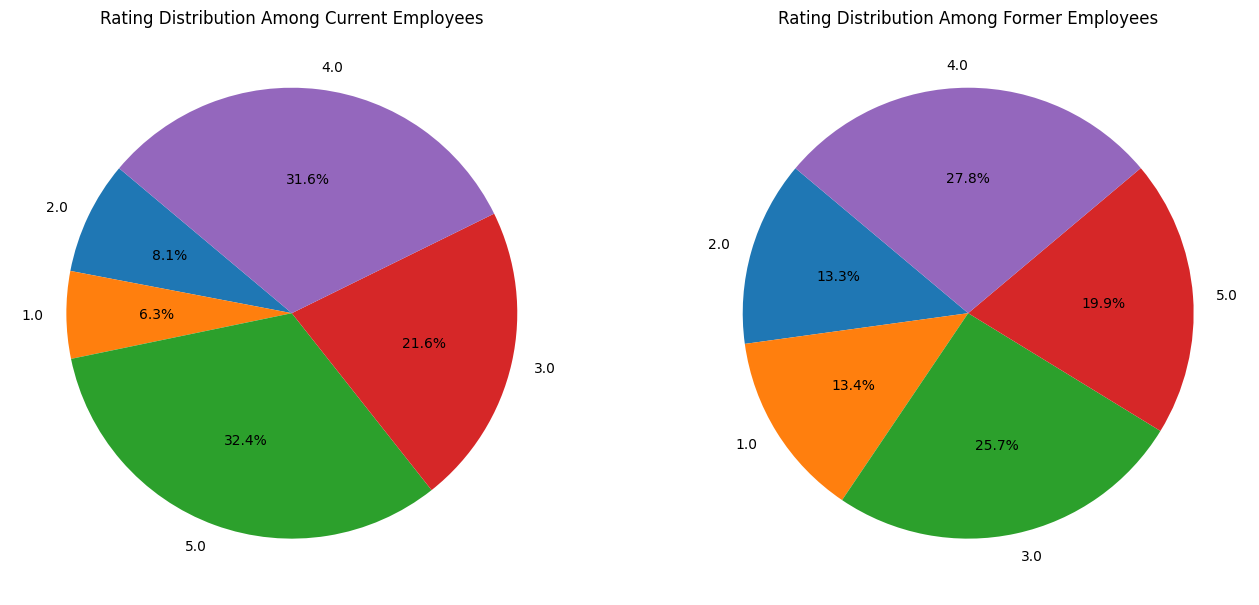

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].pie(rating_counts_df['count'], labels=rating_counts_df['rating'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Rating Distribution Among Current Employees')
axes[1].pie(rating_counts_df_former['count'], labels=rating_counts_df_former['rating'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Rating Distribution Among Former Employees')
plt.show()

funcionários atuais das empresas tendem a avaliar a empresa melhor do que funcionários antigos
ex funcionários tem uma avaliação expressivamente maior na nota 1 e levemente maior em 2 e 3
possivelmente pela condição de ex funcionário, explique as notas baixas.
Seja por demissão e entender alguma injustiça ou por pedir demissão por não gostar da empresa e consequentemente avaliar mal

In [ ]:
df = df.withColumn('rating_numeric', col('rating').cast('float'))
#transformação da coluna de rating em uma nova coluna chamada rating_numeric com type de float

In [ ]:
df = df.coalesce(1)
df = df.repartition(14, 'job')

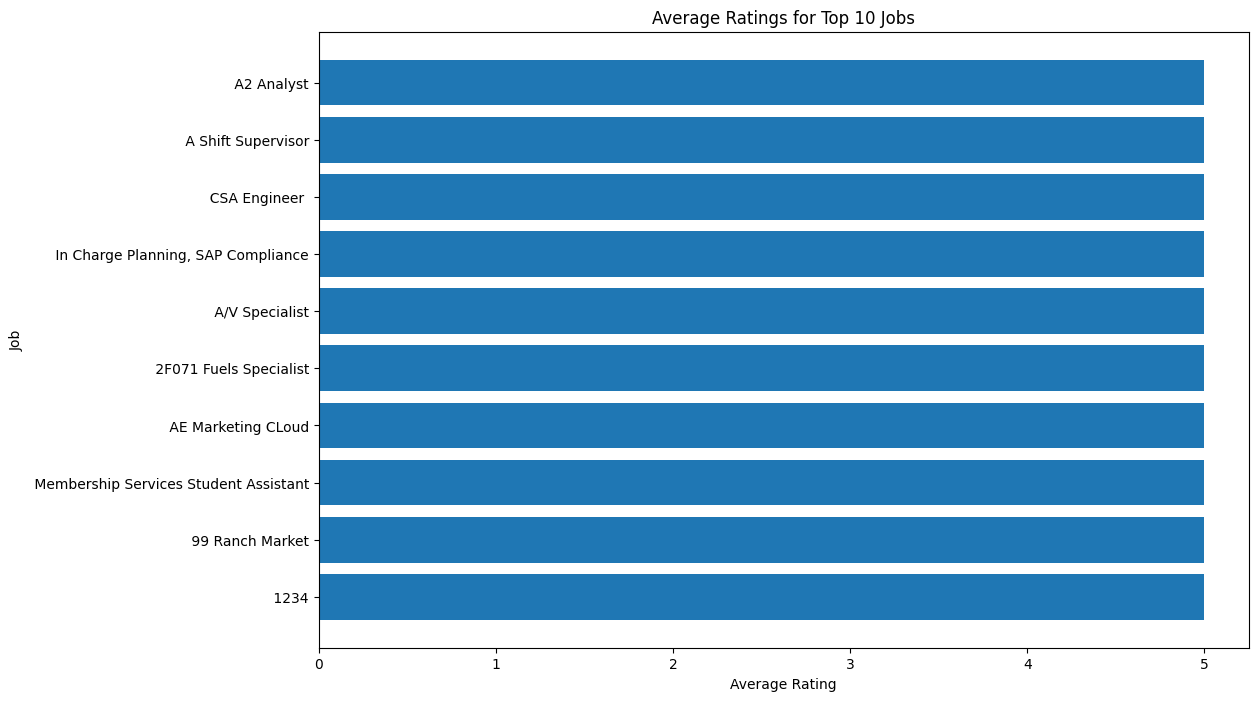

In [ ]:
average_ratings = df.groupBy('job').avg('rating_numeric').orderBy('avg(rating_numeric)', ascending=False).limit(10).toPandas()

plt.figure(figsize=(12, 8))
plt.barh(average_ratings['job'], average_ratings['avg(rating_numeric)'])
plt.title('Average Ratings for Top 10 Jobs')
plt.xlabel('Average Rating')
plt.ylabel('Job')
plt.show()

são diversos empregos com rating 5 estrelas, mas isso pode estar sendo inflado por poucas análises

In [ ]:
job_counts = df.groupBy('job').count()

filtered_jobs = job_counts.filter(col('count') >= 100)

average_ratings = df.join(filtered_jobs, on='job') \
    .groupBy('job').avg('rating_numeric') \
    .orderBy('avg(rating_numeric)', ascending=False) \
    .limit(10).toPandas()

#jobs com maior média de avaliação que tem mais de 100 entradas

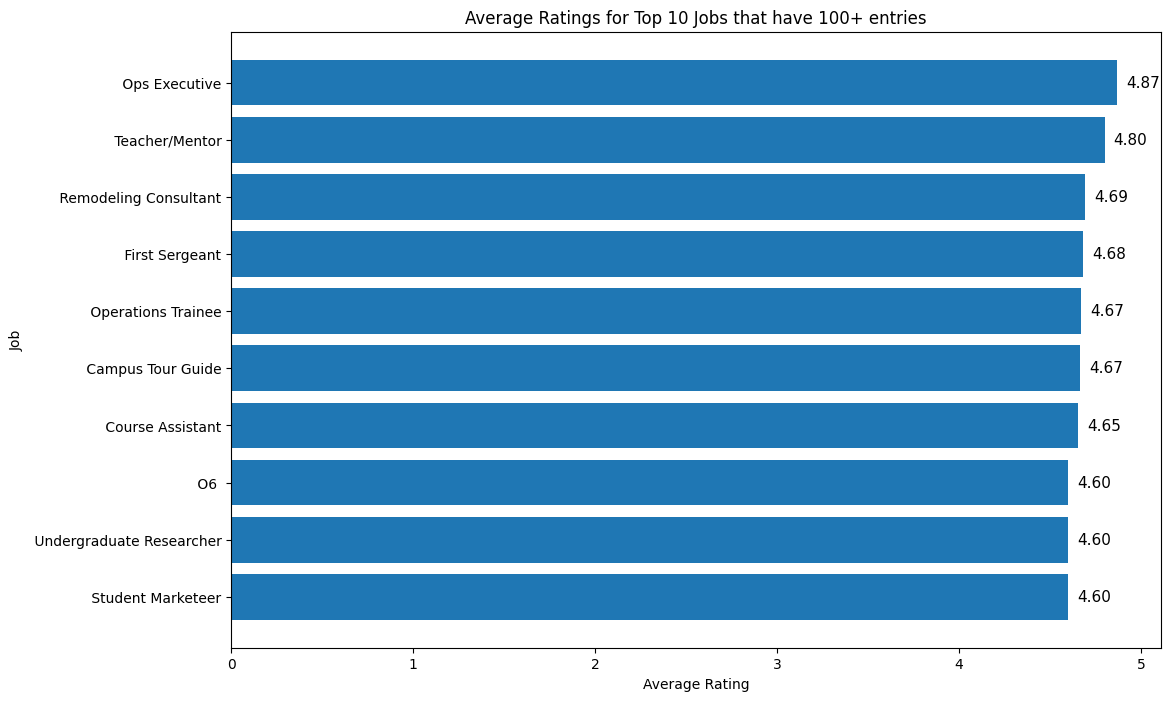

In [ ]:
plt.figure(figsize=(12, 8))
bars = plt.barh(average_ratings['job'], average_ratings['avg(rating_numeric)'])
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest ratings at the top

for bar in bars:
    plt.text(
        bar.get_width() + 0.05,
        bar.get_y() + bar.get_height() / 2, 
        f'{bar.get_width():.2f}', 
        va='center',            
        ha='left',                
        fontsize=11
    )
      
plt.title('Average Ratings for Top 10 Jobs that have 100+ entries')
plt.xlabel('Average Rating')
plt.ylabel('Job')
plt.show()

## Correlação

### Correlação Simples

para realizar os cálculos de correlação, será necessário ter números

In [ ]:
df_numeric = df.withColumn('Recommend_numeric',
                           when(col('Recommend') == 'Positive', 1)
                           .when(col('Recommend') == 'Negative', -1)
                           .when(col('Recommend') == 'Mild', 0)
                           .when(col('Recommend') == 'No opinion', 0)
                           .otherwise(0))

df_numeric = df_numeric.withColumn('CEO_Approval_numeric',
                                   when(col('CEO Approval') == 'Positive', 1)
                                   .when(col('CEO Approval') == 'Negative', -1)
                                   .when(col('CEO Approval') == 'Mild', 0)
                                   .when(col('CEO Approval') == 'No opinion', 0)
                                   .otherwise(0))

df_numeric = df_numeric.withColumn('Business_Outlook_numeric',
                                   when(col('Business Outlook') == 'Positive', 1)
                                   .when(col('Business Outlook') == 'Negative', -1)
                                   .when(col('Business Outlook') == 'Mild', 0)
                                   .when(col('Business Outlook') == 'No opinion', 0)
                                   .otherwise(0))

df_numeric = df_numeric.withColumn('employee_status_numeric',
                                   when(col('employee_status') == 'Current Employee', 1)
                                   .when(col('employee_status') == 'Former Employee', 0)
                                   .otherwise(0))

df_numeric = df_numeric.withColumn('rating_numeric', col('rating').cast('float'))

In [ ]:
df_numeric.printSchema()

root
 |-- rating: string (nullable = true)
 |-- employee_status: string (nullable = true)
 |-- Recommend: string (nullable = true)
 |-- CEO Approval: string (nullable = true)
 |-- Business Outlook: string (nullable = true)
 |-- date: string (nullable = true)
 |-- job: string (nullable = true)
 |-- rating_numeric: float (nullable = true)
 |-- Recommend_numeric: integer (nullable = false)
 |-- CEO_Approval_numeric: integer (nullable = false)
 |-- Business_Outlook_numeric: integer (nullable = false)
 |-- employee_status_numeric: integer (nullable = false)



In [ ]:
df_numeric.drop('Recommend', 'CEO Approval', 'Business Outlook', 'employee_status', 'rating')
#retirada de colunas de texto

DataFrame[rating: string, date: string, job: string, rating_numeric: float, Recommend_numeric: int, CEO_Approval_numeric: int, Business_Outlook_numeric: int, employee_status_numeric: int]

In [ ]:
df_numeric.columns

['rating',
 'employee_status',
 'Recommend',
 'CEO Approval',
 'Business Outlook',
 'date',
 'job',
 'rating_numeric',
 'Recommend_numeric',
 'CEO_Approval_numeric',
 'Business_Outlook_numeric',
 'employee_status_numeric']

In [ ]:
cols = ['rating_numeric','date','job','Recommend_numeric','CEO_Approval_numeric','Business_Outlook_numeric','employee_status_numeric']
df_numeric = df_numeric.select(cols)
df_numeric.show(10)

+--------------+-------------+-----------------+-----------------+--------------------+------------------------+-----------------------+
|rating_numeric|         date|              job|Recommend_numeric|CEO_Approval_numeric|Business_Outlook_numeric|employee_status_numeric|
+--------------+-------------+-----------------+-----------------+--------------------+------------------------+-----------------------+
|           2.0| Sep 9, 2008 |  Administrative |               -1|                   0|                       0|                      0|
|           2.0| Jul 4, 2008 |  Administrative |               -1|                   0|                       0|                      0|
|           2.0|Jul 14, 2008 |  Administrative |               -1|                   1|                       0|                      0|
|           1.0|Aug 17, 2008 |  Administrative |               -1|                   0|                       0|                      0|
|           1.0| Jul 8, 2009 |  Administr

In [ ]:
numeric_columns = ['rating_numeric','Recommend_numeric', 'CEO_Approval_numeric', 'Business_Outlook_numeric', 'employee_status_numeric']

# Replace null values with 0
for column in numeric_columns:
    df_corr_matrix = df_numeric.withColumn(column, coalesce(col(column), lit(0)))

assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
df_features = assembler.transform(df_corr_matrix)

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_features, 'features', 'pearson').head()[0]
corr_array = correlation_matrix.toArray()

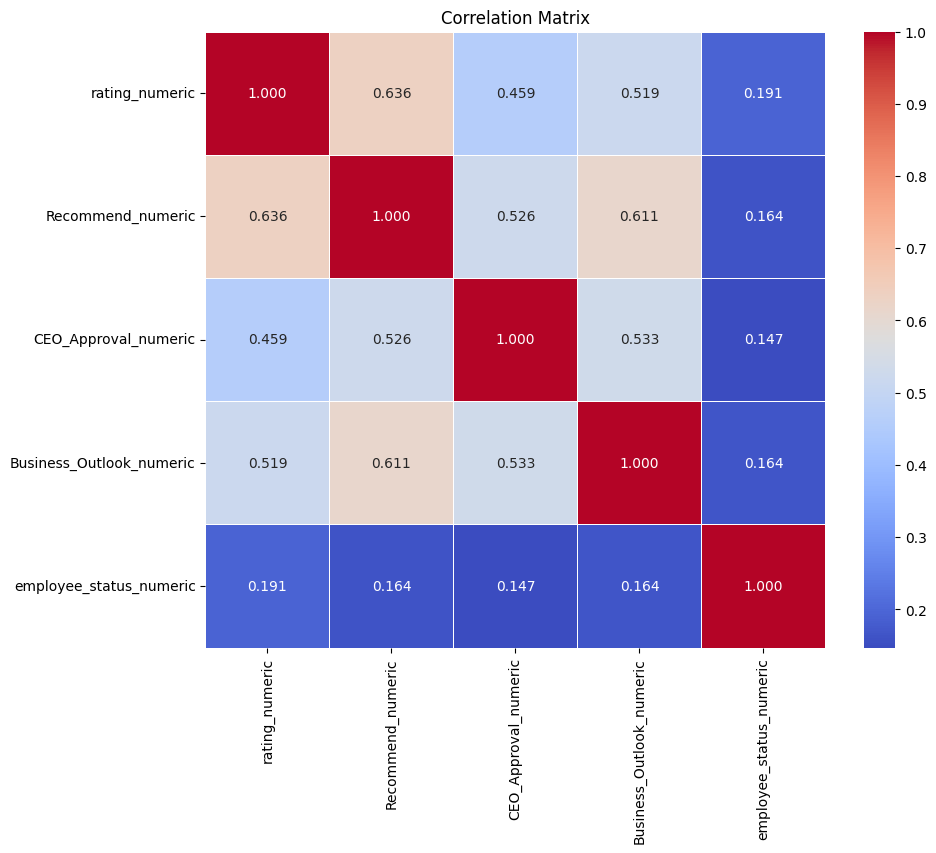

In [ ]:
corr_df = pd.DataFrame(corr_array, index=numeric_columns, columns=numeric_columns)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
ratings_index = numeric_columns.index('rating_numeric')  # Index of 'rating' column in the features vector
correlation_with_rating = {
    col_name: corr_array[i, ratings_index]
    for i, col_name in enumerate(numeric_columns) if col_name != 'rating_numeric'
}

print("Correlation with Rating:")
for col_name, corr_value in correlation_with_rating.items():
    print(f"{col_name}: {corr_value:.3f}")  

Correlation with Rating:
Recommend_numeric: 0.636
CEO_Approval_numeric: 0.459
Business_Outlook_numeric: 0.519
employee_status_numeric: 0.191
